In [1]:
from google.colab import drive
drive.mount('/content/drive')
%pip install CRPS

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
 
# from pathlib import Path
# import sys
# !sudo apt-get install unzip
# base = Path('/content/drive/MyDrive/ML/2023/lwe_dataset')
# sys.path.append(str(base))

# zip_path = base/"test.zip"


# !cp "{zip_path}" .

# !unzip -q test.zip -d "/content"

# !rm test.zip



Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import json
from tqdm import tqdm
import os
from os import listdir
from PIL import Image

import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from torch.optim import Adam
import datetime

# import wandb
# import CRPS.CRPS as pscore


from prec_dataset import RadarPrecipitationSequence
from radar_transforms import radar_transform
from plotting_funcs import show_sequence, simulate_fdp
from radar_transforms import radar_transform, reverse_transform
from fdp import forward_diffusion_sample, get_named_beta_schedule
from unet import UNet
from loss import get_loss
from sampler import sample_plot_image, sample_next_step_pred
from helper_module import get_20min_forecast_sequence
from metrics import csi
from calc_metrics import get_nowcast_20_CRPS
config = dict(
    img_out_size=64,
    rgb_grayscale=1,
    sequence_length=8,
    max_prec_val=3.4199221045419974,
    prediction_time_step_ahead=1,
    frames_to_predict=1,
    num_cond_frames=4,
    tot_pred_ahead=4,
    schedule="linear",
    T=300,

    root_dir=r"/content/lwe_dataset",
    validate_on_convective = False,
    plot_folder = "/content/drive/MyDrive/ML/results/plots/090223"
)
plot_folder = config["plot_folder"]
with open(f'{plot_folder}/config.json', 'w') as fp:
    json.dump(config, fp)

betas = get_named_beta_schedule(
    schedule_name=config["schedule"], num_diffusion_timesteps=config["T"]
)
T = config["T"]
if config["schedule"] == "linear":
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


device = "cuda" if torch.cuda.is_available() else "cpu"
model_PATH = '/content/drive/MyDrive/ML/results/plots/090122_b/model090122.pt'

### LOAD PRE-TRAINED MODEL: 

In [4]:
model = UNet(
    rgb_grayscale=config["rgb_grayscale"], num_cond_frames=config["num_cond_frames"], device=device
)
model.load_state_dict(torch.load(model_PATH))

model.to(device)
model.eval()

UNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Co

726
517
818
812
218
752
661
559
62
587
600
879
731
663
95
589
216
805
758
931


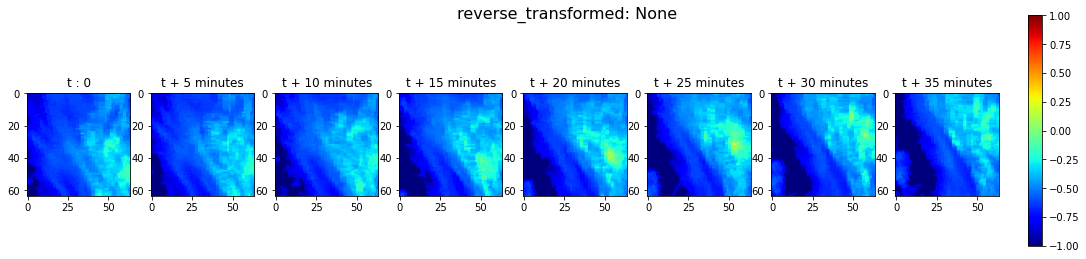

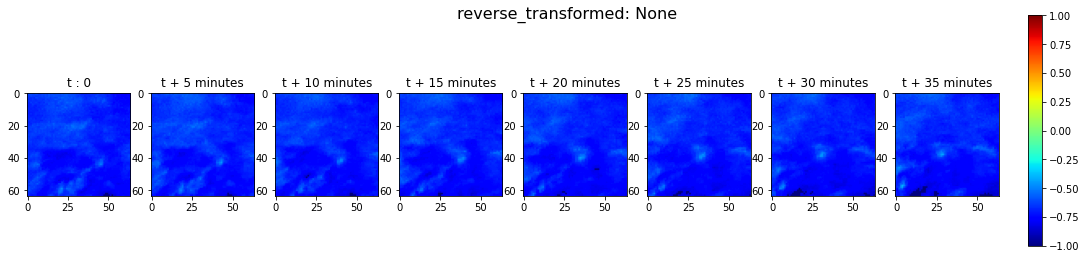

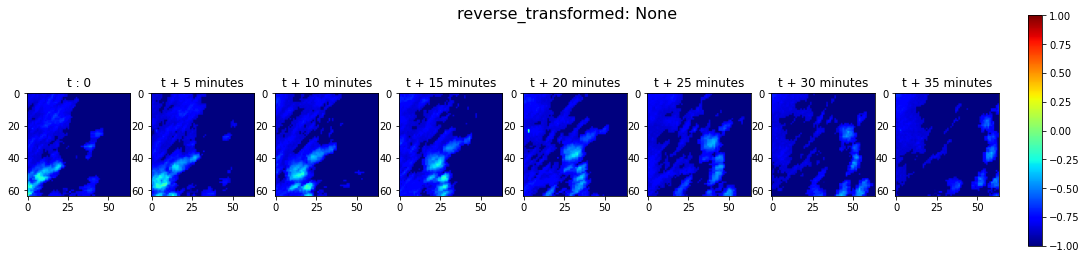

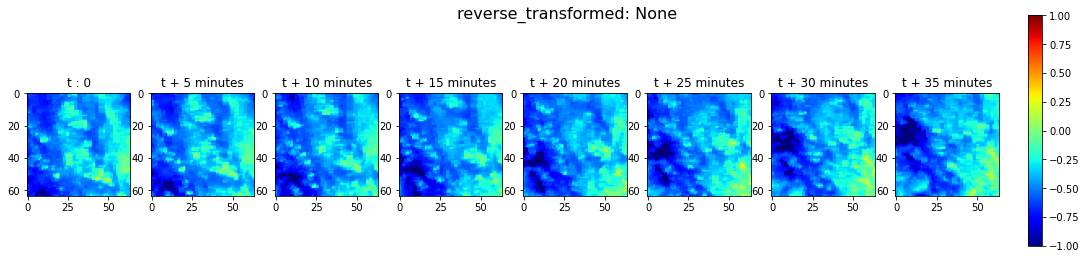

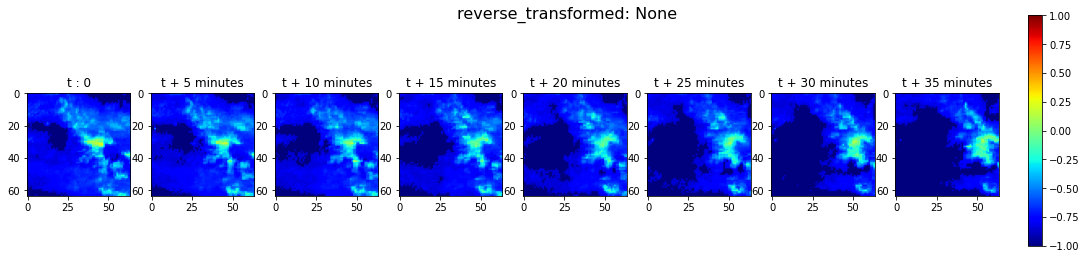

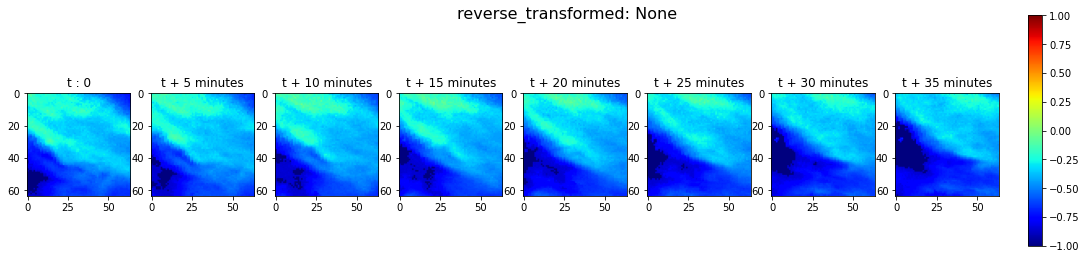

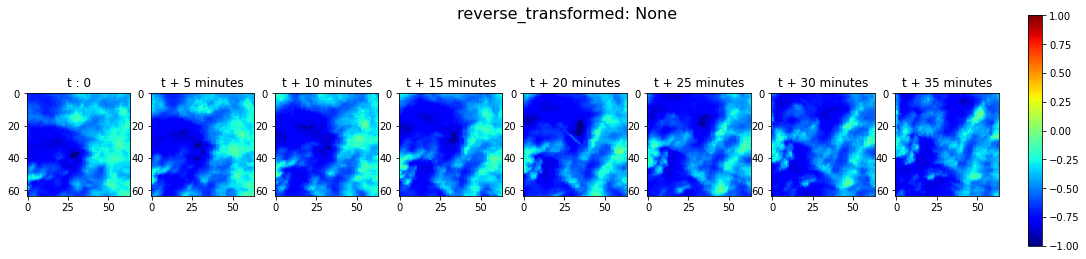

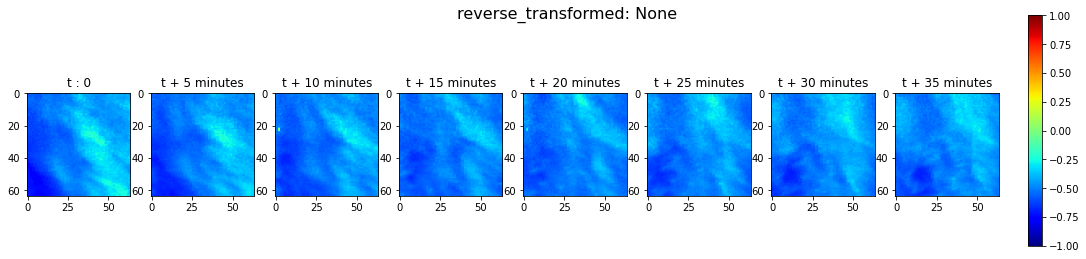

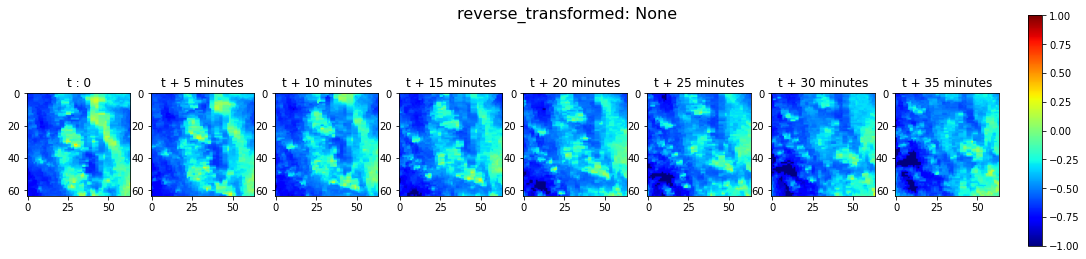

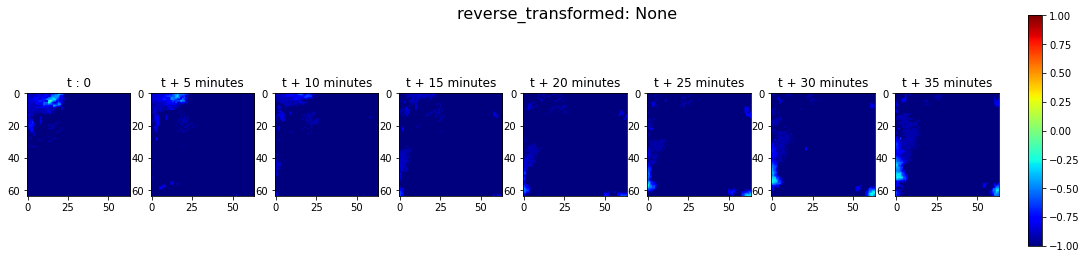

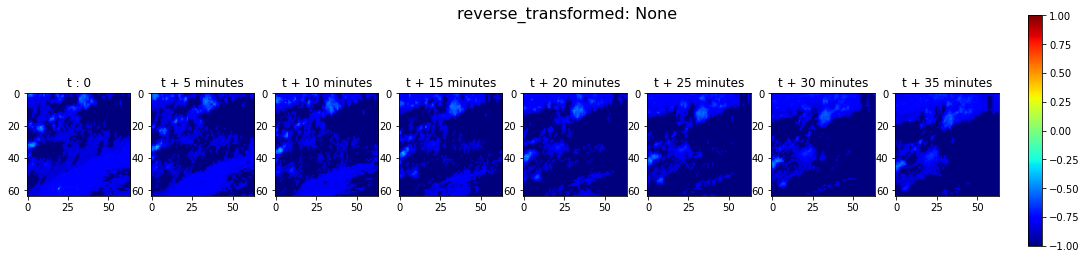

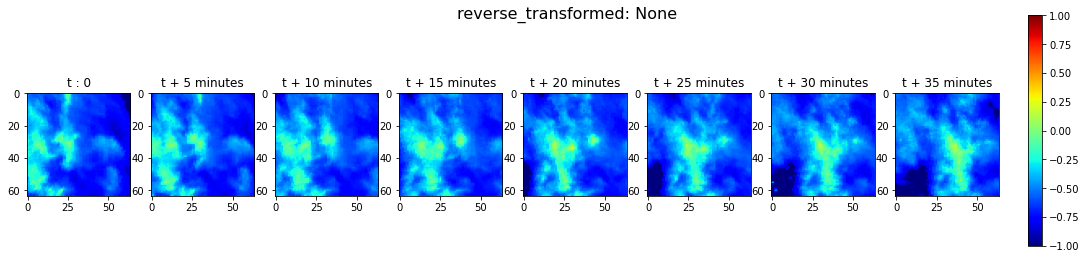

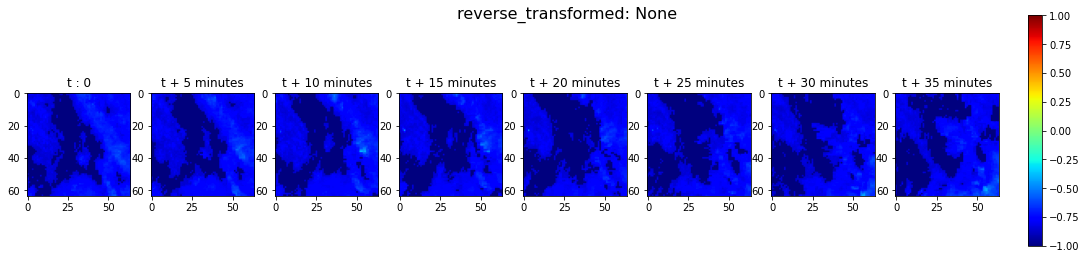

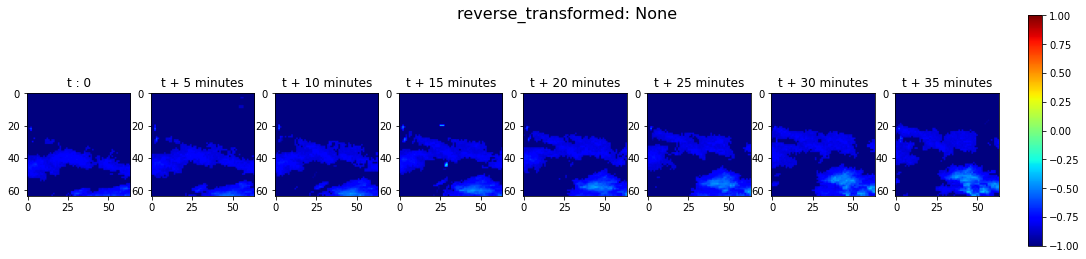

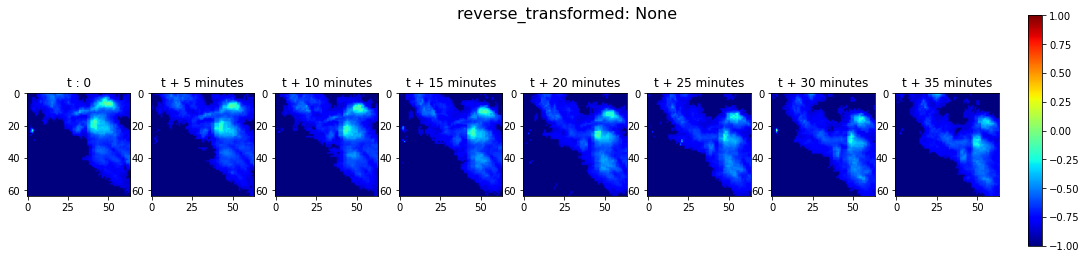

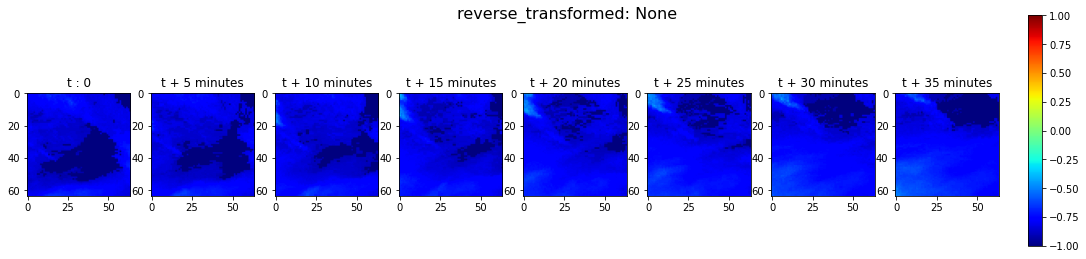

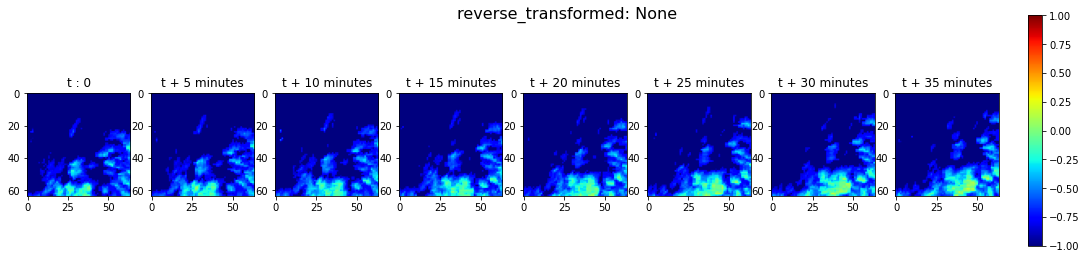

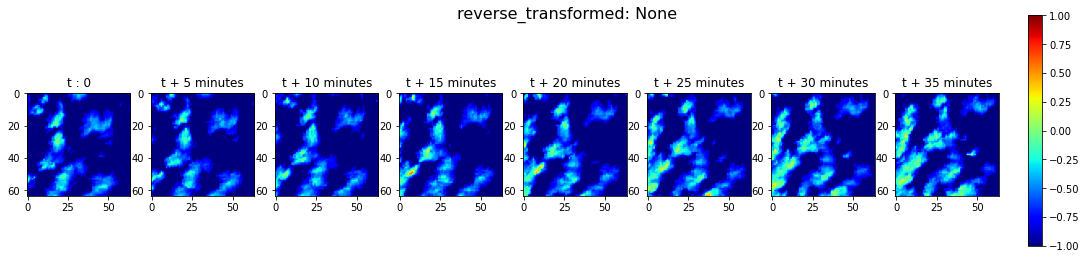

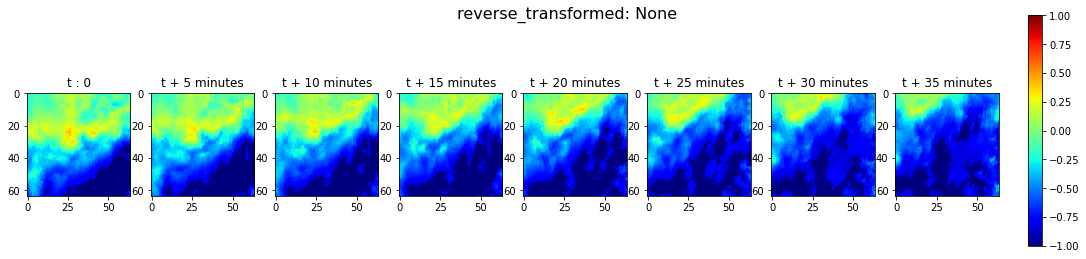

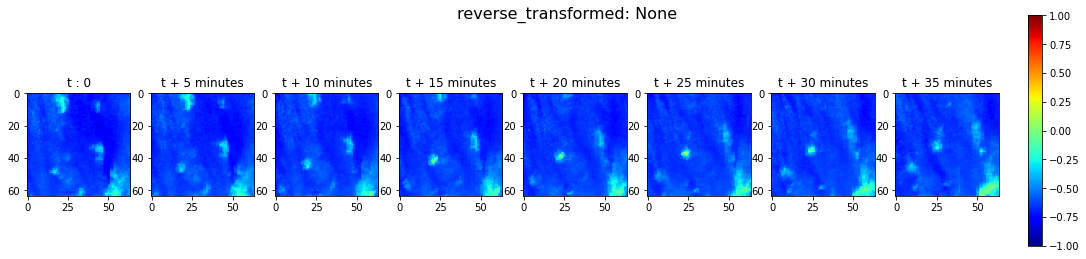

In [50]:
dataset_20min_nowcast = RadarPrecipitationSequence(
    root_dir=config["root_dir"],
    transform=radar_transform(max_prec_val=config["max_prec_val"]),
    num_cond_frames=config["num_cond_frames"],
    frames_to_predict=config["frames_to_predict"],
    img_out_size=config["img_out_size"],
    prediction_time_step_ahead=config["prediction_time_step_ahead"],
    train_test_val = "test",
    nowcast_mode = True,
    center_crop = True
)
for i in range(20):
    idx = np.random.randint(low=0, high=1000)
    train_sample = dataset_20min_nowcast.__getitem__(idx)[0]
    print(idx)
    show_sequence(train_sample, config["sequence_length"], pred_ahead= config["prediction_time_step_ahead"])

#### Get 20 minute nowcast: 

max pred seq val: 18.57761001586914
max max_data_val: 14.57101058959961
tensor(18.5776)


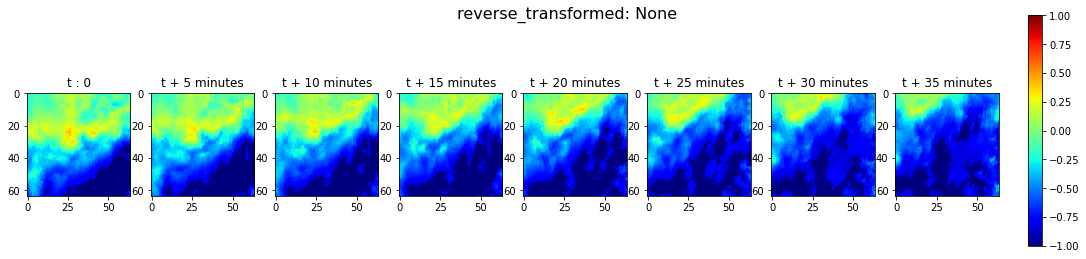

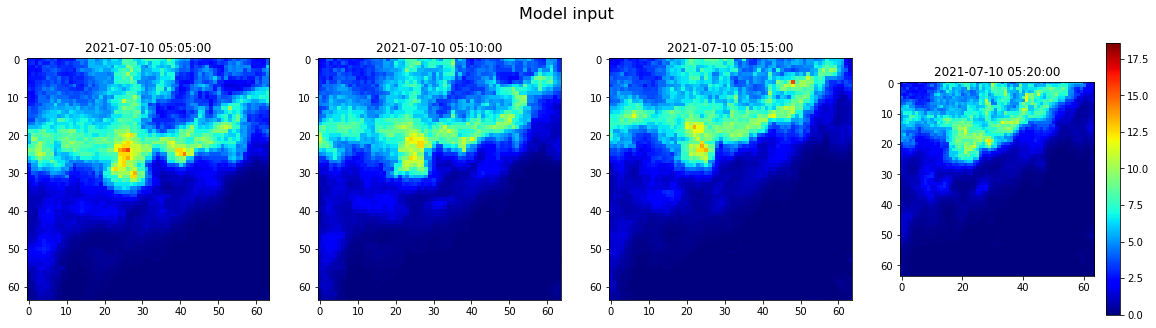

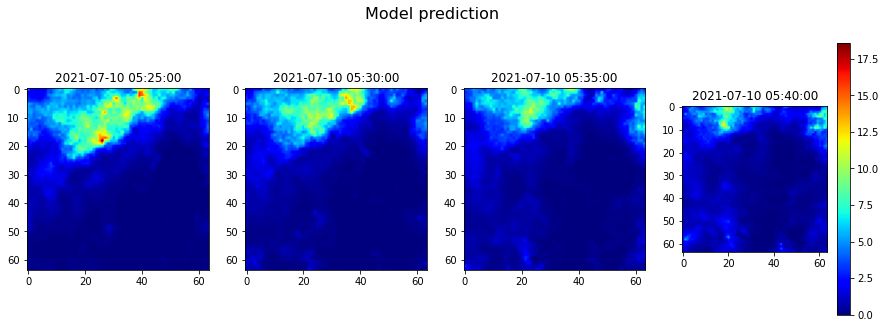

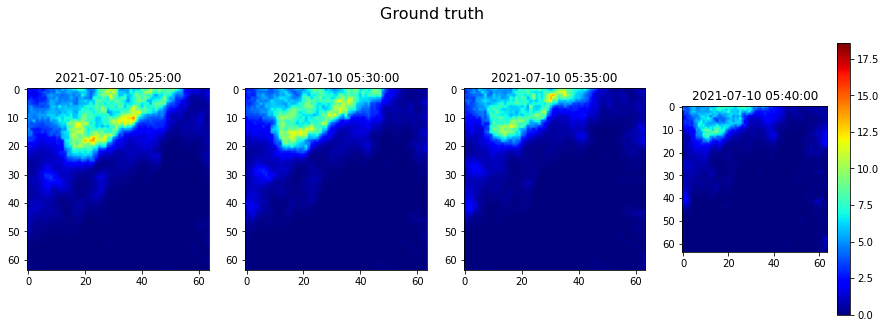

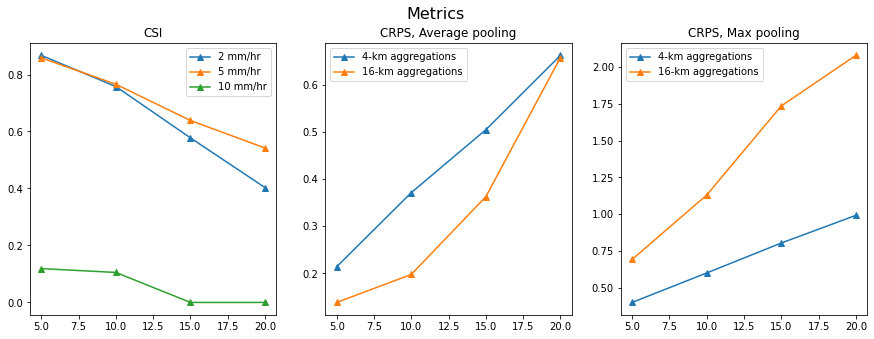

csi2: [tensor(0.8672), tensor(0.7578), tensor(0.5776), tensor(0.4031)]
csi5: [tensor(0.8586), tensor(0.7658), tensor(0.6386), tensor(0.5418)]
csi10: [tensor(0.1187), tensor(0.1053), tensor(0.), tensor(0.)]


In [55]:
# #load seq:
# idx_list = [0,1]
# seq_list = get_20min_forecast_sequence(dataset=dataset_20min_nowcast, idx_list= idx_list)
#load seq:
from calc_metrics import get_nowcast_20_CRPS

sequence_idx = 758
test_sample = dataset_20min_nowcast.__getitem__(sequence_idx)
show_sequence(test_sample[0], config["sequence_length"], pred_ahead= config["prediction_time_step_ahead"])
stamp_string = test_sample[1]
time_stamp = stamp_string.split(".")[0]
time_stamp = int(time_stamp)
stamp_arr = [time_stamp + (i * 60 * 5) for i in range(8)]

timestamp_arr = [
datetime.datetime.fromtimestamp(stamp).strftime("%Y-%m-%d %H:%M:%S")
for stamp in stamp_arr
]

prev_frames = 4
img_out_size = config["img_out_size"],
tot_pred_ahead = config["tot_pred_ahead"]

pred_seq = torch.zeros((8,64,64))
lwe_data = test_sample[0]
pred_seq[:prev_frames,:,:] = lwe_data[:prev_frames,:,:]  

# only get LWE data:

pred_seq = pred_seq[None, :, :, :]


avg4_list =[]
avg16_list =[]
max4_list =[]
max16_list =[]

for i in range(prev_frames,prev_frames+config["tot_pred_ahead"]):
    #get 4 past frames:
    cond_frames = pred_seq[:, i-prev_frames:i, :, :]

    observed_nxt_step = lwe_data[None,i, :, :]

    cond_frames = cond_frames.to(device)
    
    #pred next frame n times and get crps:
    avg_4_crps,avg_16_crps, max_4_crps,max_16_crps = get_nowcast_20_CRPS(
        cond_frames = cond_frames,
        observation = observed_nxt_step, 
        sequence_length = config['sequence_length'],
        max_prec_val = config['max_prec_val'],
        betas = betas,
        rgb_grayscale=1,
        img_out_size=64,
        device=device,
        sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
        sqrt_recip_alphas=sqrt_recip_alphas,
        posterior_variance=posterior_variance,
        model=model,
        numb_of_samples = 3,
        T = config['T']
    )
    avg4_list.append(avg_4_crps)
    avg16_list.append(avg_16_crps)
    max4_list.append(max_4_crps)
    max16_list.append(max_16_crps)

    pred_next_frame = sample_next_step_pred(
    cond_frames = cond_frames,
    device = device,
    sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod,
    sqrt_recip_alphas = sqrt_recip_alphas,
    posterior_variance = posterior_variance,
    model = model,
    T = 300,
    betas = betas,
    rgb_grayscale=1,
    img_out_size=64)
    # add to sequence
    pred_seq[:,i,:,:] = pred_next_frame

    


#process data to get prec. vals
pred_seq += 1
pred_seq /= 2
pred_seq *= config["max_prec_val"]
pred_seq **= 3
max_pred_seq = torch.max(pred_seq)
print(f'max pred seq val: {max_pred_seq}')
# lwe_data  += 1
# lwe_data  /= 2
# lwe_data  *= config["max_prec_val"]
# lwe_data  **= 3
max_data_val = torch.max(lwe_data )
print(f'max max_data_val: {max_data_val}')

max_val = max(max_pred_seq, max_data_val)
print(max_val)



fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Model input', fontsize=16)

ax1 = plt.subplot(141)
ax1.imshow((pred_seq[0, 0, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax1.set_title(f"{timestamp_arr[0]}")

ax2 = plt.subplot(142)
ax2.imshow((pred_seq[0, 1, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax2.set_title(f"{timestamp_arr[1]}")

ax3 = plt.subplot(143)
ax3.imshow((pred_seq[0, 2, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax3.set_title(f"{timestamp_arr[2]}")

ax4 = plt.subplot(144)
im4 = ax4.imshow((pred_seq[0, 3, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax4.set_title(f"{timestamp_arr[3]}")
fig.colorbar(im4)
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Model prediction', fontsize=16)

ax5 = plt.subplot(141)
ax5.imshow((pred_seq[0, 4, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax5.set_title(f"{timestamp_arr[4]}")

ax6 = plt.subplot(142)
ax6.imshow((pred_seq[0, 5, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax6.set_title(f"{timestamp_arr[5]}")

ax7 = plt.subplot(143)
ax7.imshow((pred_seq[0, 6, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax7.set_title(f"{timestamp_arr[6]}")

ax8 = plt.subplot(144)
im8 = ax8.imshow((pred_seq[0, 7, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax8.set_title(f"{timestamp_arr[7]}")
fig.colorbar(im8)

plt.show()


fig, axs = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Ground truth', fontsize=16)

ax15 = plt.subplot(141)
ax15.imshow((lwe_data[4, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax15.set_title(f"{timestamp_arr[4]}")

ax16 = plt.subplot(142)
ax16.imshow((lwe_data[5, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax16.set_title(f"{timestamp_arr[5]}")

ax17 = plt.subplot(143)
ax17.imshow((lwe_data[6, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax17.set_title(f"{timestamp_arr[6]}")

ax18 = plt.subplot(144)
im18 = ax18.imshow((lwe_data[7, :, :]), cmap="jet", vmin=0, vmax=max_val)
ax18.set_title(f"{timestamp_arr[7]}")
fig.colorbar(im18)


plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Metrics', fontsize=16)

preds = pred_seq[0,4:,:,:]
obs = lwe_data[4:,:,:]

x_time = [5,10,15,20]
csi_2 = [csi(predictions=preds[i], observed = obs[i], t=0.5) for i in range(4)]
csi_5 = [csi(predictions=preds[i], observed = obs[i], t=2) for i in range(4)]
csi_10 = [csi(predictions=preds[i], observed = obs[i], t=10) for i in range(4)]

ax25 = plt.subplot(131)
ax25.plot(x_time, csi_2, marker='^', label='2 mm/hr')
ax25.plot(x_time, csi_5, marker='^', label='5 mm/hr')
ax25.plot(x_time, csi_10, marker='^', label='10 mm/hr')
ax25.legend()
ax25.set_title(f"CSI")



ax21 = plt.subplot(132)
ax21.plot(x_time, avg4_list, marker='^', label='4-km aggregations')
ax21.plot(x_time, avg16_list, marker='^', label='16-km aggregations')
ax21.legend()
ax21.set_title(f"CRPS, Average pooling")


ax22 = plt.subplot(133)
ax22.plot(x_time, max4_list, marker='^', label='4-km aggregations')
ax22.plot(x_time, max16_list, marker='^', label='16-km aggregations')
ax22.legend()
ax22.set_title(f"CRPS, Max pooling")


plt.show()


print(f'csi2: {csi_2}')
print(f'csi5: {csi_5}')
print(f'csi10: {csi_10}')